In [76]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools", "Dates", "FiniteDifferences"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

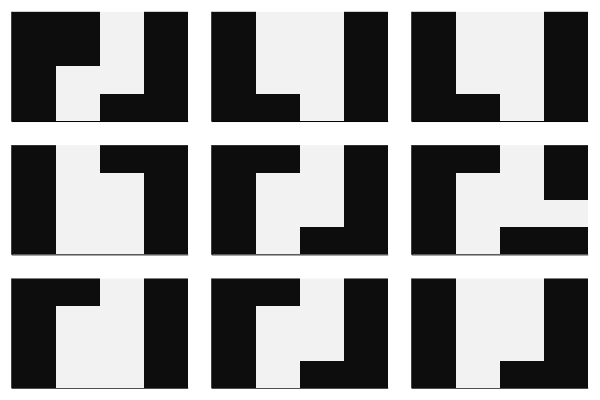

In [77]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 9 # Size of training dataset

digit = 1 # Digit to be learned
image_size = 28 # Size of image
compress_size = 4 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(compress(train_set[c][1], image_size, compress_size) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? oh well it's not a big deal


In [78]:
using Yao
using FLOYao
using Flux

N = compress_size^2 #Number of qubits

function NeuralNetwork(num_dim = N, random = true)
    net = Chain(Dense(num_dim, 25, relu), Dense(25, 1, identity))
    if !random
        for p in Flux.params(net)
            p .= (ones(size(p)) .* 0.08)
        end
    end
    return net
end

#d = NeuralNetwork() #Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) #I have no clue what this looks like, and why does it have more parameters than expected (bias?)

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N) #Making the generator, which is a matchgate ansatz (IS IT???) yes because it's made up of nn XX gates and single-qubit Z gates
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

# function build_circuit(n::Int = N, nlayers::Int = layers)
#     circuit = chain(n) #Making the generator, which is a matchgate ansatz; this just uses Yao though? or does saying "using FLOYao" somehow change the implementation... Not really sure
#     for _ in 1:nlayers
#         for i in 1:N-1
#             push!(circuit, rot(kron(N, i => X, i+1 => X), 0.))
#         end
#         for i in 1:N
#             push!(circuit, put(N, i => Rz(0.)))
#         end
#     end
# end

#g = build_circuit()
#g = build_circuit() |> autodiff(:QC)

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, ones(nparams) ./ 100); 
dispatch!(g, :random);

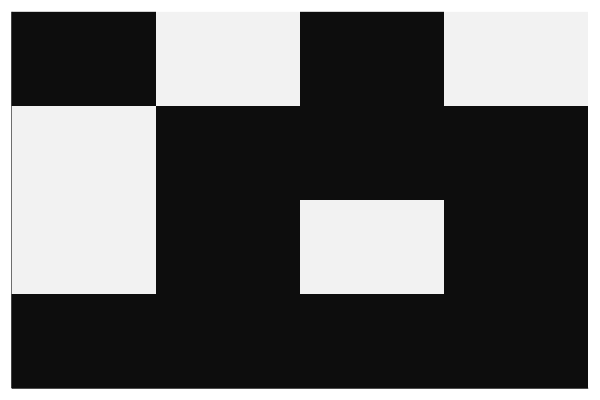

In [79]:
using FLOYao
using Random
using Distributions

#Not sure if there is a better pprior that we can choose, sometimes u get a lot of white or black bc variance is high (resolution: change var from sigma to sigma/10)
mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
#dist = Normal(mu, sigma/20)
dist = Normal(mu, 1)

ratio = rand(dist) / N
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [80]:
using Flux: train!

batch_size = train #Are you supposed to randomly pick batch_size data points at random each time if train is big? idk

#g takes as input x = Int.(pprior()); FLOYao.product_state(x)
#d takes as input measure(x |> g)

function convertgd(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

function run_circuit(z::MajoranaReg) #z is a MajoranaReg drawn from pprior (to guarantee matchgate speedup); this function applies D(G(z))
    g_output = z |> g |> measure
    d_input = convertgd(g_output)
    d_output = d_input |> d
    d_output |> first
end

t = time()
measurement = run_circuit(pprior())
println("runcircuit: $measurement")
println(time() - t)

function run_d(x::BitMatrix) #this function applies D(x), where x is an element of data_train 
    d_output = x |> vec |> d
    d_output |> first
end

function gLoss(z::MajoranaReg) #z is sampled from pprior()
    -log(run_circuit(z))
    #log(1 - run_circuit(z))
end

function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end

# function dLoss(m, fake)
#     -(log.(m(real)) + log.(1 .- m(fake))) |> first
# end

# Worry about this another day
# function gradient(op, reg::MajoranaReg) #does expect' (from FLOYao? or does it come from Yao?) use AD? Also idk what op should be
#     _, params_grad = expect'(op, reg => g)
# end
ε = 0.001 
function finitediff_grad(z::MajoranaReg, eps = ε) #Returns the approximate gradient of G, using forward finite differences
    original = gLoss(z)
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    temp = 0
    for i in 1:nparameters(g)
        temp = parameters(g)[i]
        temp_params[i] = temp + eps
        dispatch!(g, temp_params)
        plus = gLoss(z)
        grad[i] = (plus - original) / eps
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end
#dispatch! takes a (sorta) long time, and when you're doing it 2*nparameters(g) times...

# function finitediff_grad(z::MajoranaReg)
# end

# function finitediff_grad(z::MajoranaReg, eps = ε) #Returns the approximate gradient of G, using central finite differences
#     temp_params = parameters(g)
#     grad = zeros(nparameters(g))
#     temp = plus = minus = 0
#     for i in 1:nparameters(g)
#         temp = parameters(g)[i]
#         temp_params[i] = temp + eps
#         dispatch!(g, temp_params)
#         plus = gLoss(z)
#         temp_params[i] = temp - eps
#         dispatch!(g, temp_params)
#         minus = gLoss(z)
#         grad[i] = (plus - minus) / (2*eps)
#         temp_params[i] = temp
#         dispatch!(g, temp_params)
#     end
#     grad
# end

z = pprior()
@time finitediff_grad(z);

In [81]:
g_lr = 0.0001
d_lr = 0.5

opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d) #lol is this right
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d) #yeah idk anymore
end

gLoss_values = []
dLoss_values = []
g_epochs = 50
d_epochs = 3
epochs = 10

fake_samples = []
for m in 1:batch_size
    z = pprior()
    push!(fake_samples, z)
end

# for j in 1:1
#     s = 0
#     grads = []
#     for m in 1:batch_size
#         z = fake_samples[m]
#         push!(grads, finitediff_grad(z, ε))
#         s += gLoss(z)
#     end
#     dispatch!(-, g, mean(grads) * g_lr)
#     #println("Generator loss for g_epoch $j:", s / batch_size)
#     push!(gLoss_values, s / batch_size)
# end

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        s = 0
        grads = []
        for m in 1:batch_size
            z = fake_samples[m]
            push!(grads, finitediff_grad(z, ε))
            s += gLoss(z)
        end
        println(mean(grads))
        dispatch!(-, g, mean(grads) * g_lr)
        push!(gLoss_values, s / batch_size)
    end
    for j in 1:d_epochs
        real = []
        fake = []
        for m in 1:batch_size
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            z = pprior()
            push!(fake, convertgd(z |> g |> measure))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_values, s / batch_size)
    end
    println("iteration $i done in: ", time() - t)
end

for j in 1:500
    s = 0
    grads = []
    for m in 1:batch_size
        z = fake_samples[m]
        push!(grads, finitediff_grad(z, ε))
        s += gLoss(z)
    end
    dispatch!(-, g, mean(grads) * g_lr)
    #println("Generator loss for g_epoch $j:", s / batch_size)
    push!(gLoss_values, s / batch_size)
end

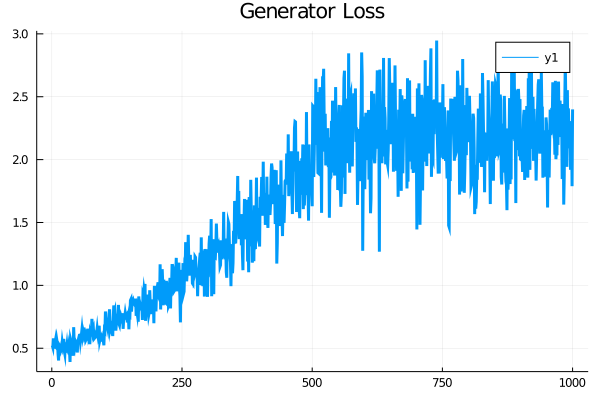

In [82]:
println("Generator loss")

# for l in gLoss_values
#     println(l)
# end

plot(gLoss_values, title = "Generator Loss", linewidth=3)

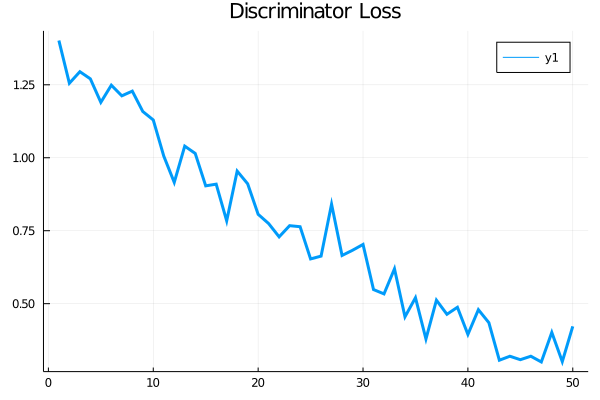

In [83]:
println("Discriminator loss")

# for l in dLoss_values
#     println(l)
# end

plot(dLoss_values, title = "Discriminator Loss", linewidth=3)

In [84]:
#Testing the Discriminator

d_fake = run_circuit(pprior())
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = run_d(data_train[index])
println("real data: $d_real") #Should print a number close to 1

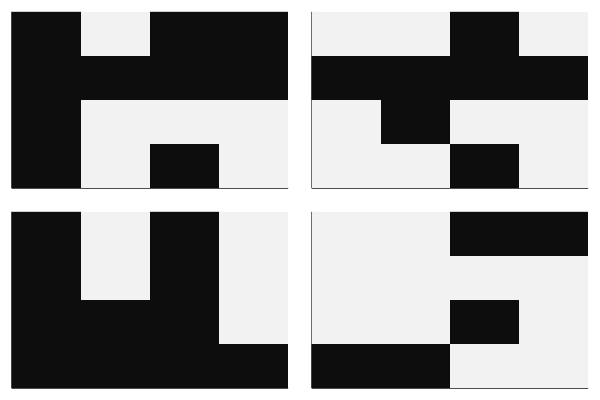

In [85]:
#Testing the Generator

nsamples = 4
samples = []
for i in 1:nsamples
    reg = fake_samples[i]
    s = reg |> g |> measure
    push!(samples, convertgd(s))
end
plot([heatmap(rotl90(reshape(s, compress_size, compress_size)), color=:grays, colorbar = false, ticks = false) for s in samples]...) #Not sure if the reshaping is correct but whatever